#**Training a Model 'model_v8' on Dataset**<br>

*   List item
*   List item


Author: Jatin Kadge<br>
Roll No.: EE23D021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getcsv_from_raw(file):
  # Replace with your actual CSV file path
  csv_file = file

  # Read the CSV file into a DataFrame
  df = pd.read_csv(csv_file, header=None)

  # Split the first column into timestamp and numerical values
  #df[0] = df[0].str.split(" -> ")
  #df[["timestamp", "values"]] = pd.DataFrame(df[0].tolist(), index=df.index)
  #df.drop(columns=[0], inplace=True)

  # Rename columns
  df.columns = [ "Ax", "Ay", "Az", "Gx", "Gy","Gz", "timestamp"]

  # Reordering columns
  f = df[["timestamp", "Ax", "Ay", "Az", "Gx", "Gy", "Gz"]]
  return f

In [3]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
left_swing = getcsv_from_raw('/content/drive/MyDrive/Wearable_devices_newdata/Data/left-swing_1000-data.csv')
right_swing = getcsv_from_raw('/content/drive/MyDrive/Wearable_devices_newdata/Data/right-swing_1000-data.csv')
no_motion = getcsv_from_raw('/content/drive/MyDrive/Wearable_devices_newdata/Data/no-motion_1000-data.csv')
flexion = getcsv_from_raw('/content/drive/MyDrive/Wearable_devices_newdata/Data/flexion-2_1000-data.csv')
adduction = getcsv_from_raw('/content/drive/MyDrive/Wearable_devices_newdata/Data/adduction-2_1000-data.csv')

####**Assigning unique values to guestures**

In [5]:
def combine_data(gesture, df):
  df['gesture'] = gesture
  return df

In [6]:
final_l = combine_data(1,left_swing)            # left = 1 rough value
final_r = combine_data(2,right_swing)           # right = 2
final_n = combine_data(0,no_motion)             # no_motion = 0 rough value
final_adduction = combine_data(3,adduction)     # adduction = 3 rough value
final_flexion = combine_data(4,flexion)         # flexion = 4 rough value

####**Seperating the data into 80:20 ration for Trainin and Testing**

In [7]:
def test_train(d2):
  # features and output columns for training set 80% of input data
  x_train = d2.iloc[:round(0.8*(d2.shape[0])), :-1]
  y_train = d2.iloc[:round(0.8*(d2.shape[0])), -1]

  # features and output columns for validation set 20% of input data
  x_validation = d2.iloc[round(0.8*len(d2)):, :-1]
  y_validation = d2.iloc[round(0.8*len(d2)):, -1]
  return x_train, y_train, x_validation, y_validation

In [8]:
l_x_train,l_y_train,l_x_validation,l_y_validation = test_train(final_l)
r_x_train,r_y_train,r_x_validation,r_y_validation = test_train(final_r)
n_x_train,n_y_train,n_x_validation,n_y_validation = test_train(final_n)

adduction_x_train,adduction_y_train,adduction_x_validation,adduction_y_validation = test_train(final_adduction)
flexion_x_train,flexion_y_train,flexion_x_validation,flexion_y_validation = test_train(final_flexion)

####**Preprocessing the Train Test data before pushing it to ML Algorithem**

In [9]:
def convert_to_np(df,k):
  if (k==0):
    n_timesteps = 10
    n_features = 6

    # Load the data from your dataframele\\
    data = df.copy()

    # Drop the timestamp column
    data = data.drop(columns=['timestamp'])

    # Determine the number of samples
    num_samples = len(data) // n_timesteps

    # Trim the data to only include full samples
    data = data.iloc[:num_samples * n_timesteps]

    # Convert the data to a 3D format
    data_3d = data.values.reshape((num_samples, n_timesteps, n_features))

    # Print the shape of the resulting data
    return data_3d
  else:
    df = df.iloc[:df.shape[0]//10]
    x = (np.array(df.values)).reshape(df.shape[0],1)
    return x

In [10]:
# converting the dataframes to numpy arrays for efficient calculation
x_train = convert_to_np(l_x_train,0)
x_train = np.vstack((x_train,convert_to_np(r_x_train,0)))
x_train = np.vstack((x_train,convert_to_np(n_x_train,0)))
x_train = np.vstack((x_train,convert_to_np(flexion_x_train,0)))
x_train = np.vstack((x_train,convert_to_np(adduction_x_train,0)))

y_train = convert_to_np(l_y_train,1)
y_train = np.vstack((y_train,convert_to_np(r_y_train,1)))
y_train = np.vstack((y_train,convert_to_np(n_y_train,1)))
y_train = np.vstack((y_train,convert_to_np(flexion_y_train,1)))
y_train = np.vstack((y_train,convert_to_np(adduction_y_train,1)))

x_validation = convert_to_np(l_x_validation,0)
x_validation = np.vstack((x_validation,convert_to_np(r_x_validation,0)))
x_validation = np.vstack((x_validation,convert_to_np(n_x_validation,0)))
x_validation = np.vstack((x_validation,convert_to_np(flexion_x_validation,0)))
x_validation = np.vstack((x_validation,convert_to_np(adduction_x_validation,0)))


y_validation = convert_to_np(l_y_validation,1)
y_validation = np.vstack((y_validation,convert_to_np(r_y_validation,1)))
y_validation = np.vstack((y_validation,convert_to_np(n_y_validation,1)))
y_validation = np.vstack((y_validation,convert_to_np(flexion_y_validation,1)))
y_validation = np.vstack((y_validation,convert_to_np(adduction_y_validation,1)))

#### **Training the machine learning model over the data**

In [11]:
# converting the numpy arrays to tensors
import tensorflow as tf

def conv_tensor(x):
  t = tf.convert_to_tensor(x.astype('float32'))
  return t

In [12]:
print('TensorFlow ' + tf.__version__)

TensorFlow 2.13.0


Importing the necessary modules for the machine learning model

In [13]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import MaxPooling1D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

##### **ML model**

Over here we used a sequential convolutional neural network. The data consisted of m samples, where each sample had 10 subsequent time stamps and each time stamp containing 6 features.

This is a sequential model with the following layers


1. Conv1D layer with 64 filters, kernel size of 3 and ReLU activation, with input shape of (n_timesteps, n_features).
2. Another Conv1D layer with 64 filters, kernel size of 3 and ReLU activation.
3. A dropout layer with 0.5 dropout rate.
4. A MaxPooling1D layer with pool size of 2.
5. A flatten layer.
6. A dense layer with 100 neurons and ReLU activation.
7. Another dense layer with n_outputs neurons and softmax activation.

The model is compiled with categorical cross-entropy loss, adam optimizer and accuracy metric. It is trained with the given trainX and trainy data for a specified number of epochs and batch size. Finally, the accuracy of the model is evaluated on the testX and testy data.

###### **4**
This is a model having **500 epochs**. This means that the training data will pass throught the model 500 times so that the model can see hidden patterns which were not seen in the initial iterations.

4/4 [==============================] - 0s 3ms/step
>#1: 99.000
4/4 [==============================] - 0s 4ms/step
>#2: 100.000
4/4 [==============================] - 0s 3ms/step
>#3: 100.000
4/4 [==============================] - 0s 3ms/step
>#4: 99.000
4/4 [==============================] - 0s 3ms/step
>#5: 99.000
4/4 [==============================] - 0s 4ms/step
>#6: 100.000
4/4 [==============================] - 0s 3ms/step
>#7: 100.000
4/4 [==============================] - 0s 4ms/step
>#8: 100.000
4/4 [==============================] - 0s 3ms/step
>#9: 100.000
4/4 [==============================] - 0s 6ms/step
>#10: 100.000
[99.00000095367432, 100.0, 100.0, 99.00000095367432, 99.00000095367432, 100.0, 100.0, 100.0, 100.0, 100.0]
Accuracy: 99.700% (+/-0.458)


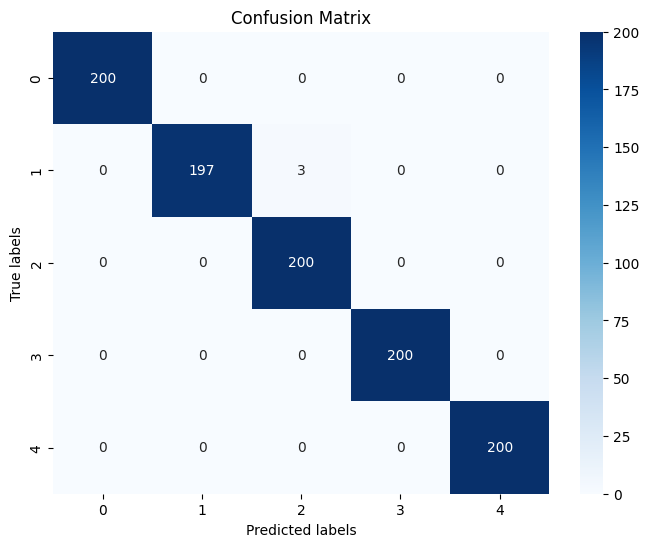

In [14]:
# One-hot encode integer labels
y_train_one_hot = to_categorical(y_train)
y_validation_one_hot = to_categorical(y_validation)

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 500, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv2D(filters=16, kernel_size=(3,1), activation='relu', input_shape=(n_timesteps,n_features,1)))
	model.add(Conv2D(filters=16, kernel_size=(3,1), activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling2D(pool_size=(2,1)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

	#######SAVING The MODEL
	model.save("/content/drive/MyDrive/Wearable_devices_newdata/ML_models/model_v8.keras")


	########Loading the model
	loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Wearable_devices_newdata/ML_models/model_v8.keras")

	# confusion matrix
	y_pred = loaded_model.predict(testX)
	y_true = [np.argmax(testy[i]) for i in range(len(testy))]
	y_pred_classes = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
	confusion_mtx = confusion_matrix(y_true, y_pred_classes)

	# evaluate model
	_, accuracy = loaded_model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy, confusion_mtx

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = conv_tensor(x_train),conv_tensor(y_train_one_hot),conv_tensor(x_validation),conv_tensor(y_validation_one_hot)
	# repeat experiment
	total_conf = np.zeros([5,5])
	scores = list()
	for r in range(repeats):
		score, confusion_mtx = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
		total_conf+=confusion_mtx

	# summarize results
	summarize_results(scores)
	fig, ax = plt.subplots(figsize=(8, 6))
	sns.heatmap(total_conf, annot=True, cmap='Blues', fmt='g', ax=ax)
	ax.set_xlabel('Predicted labels')
	ax.set_ylabel('True labels')
	ax.set_title('Confusion Matrix')
	plt.show()
# run the experiment
run_experiment()